<a href="https://colab.research.google.com/github/ldivrala/Transformer-Architecture/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import random
import math
import json
from functools import partial

import matplotlib.pyplot as plt
plt.set_cmap("cividis")
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg", "pdf")
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams["lines.linewidth"] = 2.0
import seaborn as sns
sns.reset_orig()

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim


import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

try:
  import pytorch_lighting as pl
except ModuleNotFoundError:
  !pip install pytorch-lightning==1.3.4
  import pytorch_lightning as pl

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

DATASET_PATH = "../data"
CHECKPOINT_PATH = "../saved_models/tutorial16"

pl.seed_everything(42)


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

     |████████████████████████████████| 806 kB 7.4 MB/s 
     |████████████████████████████████| 282 kB 69.0 MB/s 
     |████████████████████████████████| 119 kB 74.7 MB/s 
     |████████████████████████████████| 636 kB 60.7 MB/s 
     |████████████████████████████████| 829 kB 53.8 MB/s 
     |████████████████████████████████| 1.3 MB 51.8 MB/s 
     |████████████████████████████████| 294 kB 70.7 MB/s 
     |████████████████████████████████| 142 kB 71.2 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=45a837eba4c08c95afbd01eb8cd84bd35ae490ce3c667ebc66e0b4c98494f1b8
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0

Global seed set to 42


device(type='cuda', index=0)

Scaled dot product of Query, Key and Value

In [2]:
def scaled_dot_product(q, k ,v, mask = None):
  d_k = q.size()[-1]
  attn_logits = torch.matmul(q, k.transpose(-2, -1))
  attn_logits = attn_logits/ math.sqrt(d_k)
  if mask is not None:
    attn_logits = attn_logits.masked_fill(mask == 0, -9e15)

  attention = F.softmax(attn_logits, dim = -1)
  values = torch.matmul(attention, v)

  return values, attention

In [3]:
seq_len, d_k = 3, 2
pl.seed_everything(42)
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Global seed set to 42


Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values
 tensor([[ 0.5698, -0.1520],
        [ 0.5379, -0.0265],
        [ 0.2246,  0.5556]])
Attention
 tensor([[0.4028, 0.2886, 0.3086],
        [0.3538, 0.3069, 0.3393],
        [0.1303, 0.4630, 0.4067]])


Multi head attention layers with the help of Q,K,V

In [4]:
class MultiheadAttention(nn.Module):
    
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)
        
        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)
        
        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)
        
        if return_attention:
            return o, attention
        else:
            return o

Encoder Block

In [5]:
class EncoderBlock(nn.Module):
  def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
    super().__init__()
    self.multi_head = MultiheadAttention(input_dim, input_dim, num_heads)

    self.linear_net = nn.Sequential(
                                     nn.Linear(input_dim, dim_feedforward),
                                     nn.Dropout(dropout),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(dim_feedforward, input_dim)
    )

    self.norm1 = nn.LayerNorm(input_dim)
    self.norm2 = nn.LayerNorm(input_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, mask = None):
    attn_out = self.multi_head(x, mask)
    x = x + self.dropout(attn_out)
    x = self.norm1(x)

    linear_out = self.linear_net(x)
    x = x + self.dropout(linear_out)
    x = self.norm2(x)

    return x

Here for our purpose we will create only transformer encoder

In [6]:
class TransformerEncoder(nn.Module):
  def __init__(self, num_layers, **block_args):
    super().__init__()
    self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

  def forward(self, x, mask = None):
    for l in self.layers:
      x = l(x, mask=mask)

    return x

  def get_attention_maps(self, x, mask = None):
    attention_maps = []

    for l in self.layers:
      _, atten_map = l.multi_head(x, mask = mask, return_attention = True)
      attention_maps.append(atten_map)
      x = l(x)

    return attention_maps

Position Embedding

In [7]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=5000):
    # d_model = positional encoding length == (Input Encoding length)
    # max_len = max_sequence length
    super().__init__()

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = 1/(10000 ** (torch.arange(0, d_model, 2).float()/ d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)

    self.register_buffer("pe", pe, persistent = False)

  def forward(self, x):
    x = x + self.pe[:, :x.size(1)]
    return x


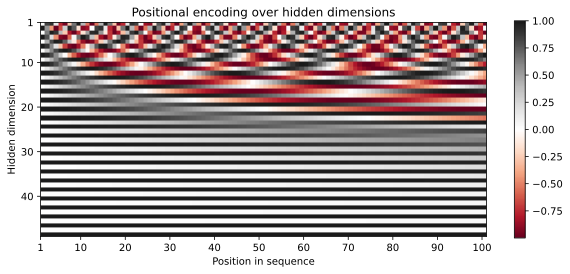

In [8]:
encod_block = PositionalEncoding(48, 100)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 4))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

Analyze position embedding

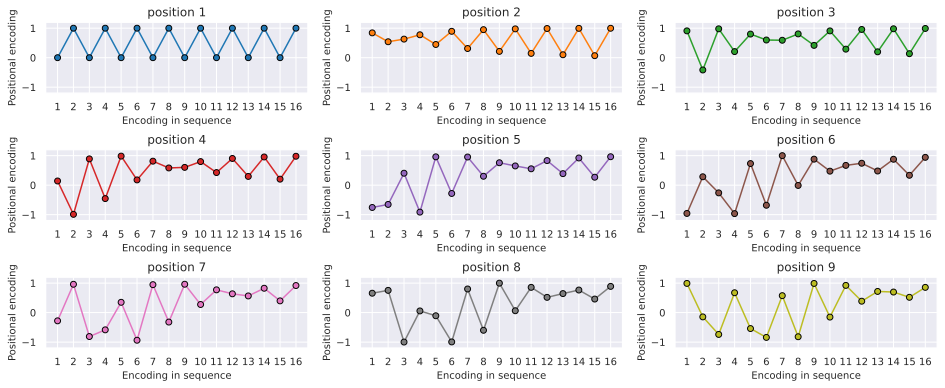

In [9]:
sns.set_theme()
fig, ax = plt.subplots(3, 3, figsize=(16, 6 ))
ax = [a for a_list in ax for a in a_list]

for i in range(len(ax)):
  ax[i].plot(np.arange(1, 17), pe[:16, i], color='C%i'%i, marker = "o", markersize= 6, markeredgecolor="black")
  ax[i].set_title("position %i" % (i+1))
  ax[i].set_xlabel("Encoding in sequence", fontsize=10)
  ax[i].set_ylabel("Positional encoding", fontsize=10)
  ax[i].set_xticks(np.arange(1, 17))
  ax[i].tick_params(axis="both", which="major", labelsize=10)
  ax[i].tick_params(axis="both", which="minor", labelsize=8)
  ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

First we have to increase our LR form low to high so there will be no gradient boosting problem

In [10]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
  def __init__(self, optimizer, warmup, max_iters):
    self.warmup = warmup
    self.max_num_iters = max_iters
    super().__init__(optimizer)

  def get_lr(self):
    lr_factor = self.get_lr_factor(epoch = self.last_epoch)
    return [base_lr * lr_factor for base_lr in self.base_lrs]

  def get_lr_factor(self, epoch):
    lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
    if epoch <= self.warmup:
      lr_factor *= epoch * 1.0 / self.warmup
    
    return lr_factor

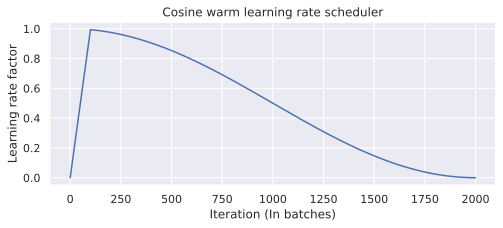

In [11]:
p = nn.Parameter(torch.empty(4, 4))
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer, 100, max_iters=2000)

epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.xlabel("Iteration (In batches)")
plt.ylabel("Learning rate factor")
plt.title("Cosine warm learning rate scheduler")
plt.show()
sns.reset_orig()

We will create predictor with the help of transformer encoder \
Anomaly detection

In [12]:
class TransformerPredictor(pl.LightningModule):
  def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0):
    super().__init__()
    self.save_hyperparameters()
    self._create_model()

  def _create_model(self):
    self.input_net = nn.Sequential(
        nn.Dropout(self.hparams.input_dropout),
        nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
    )

    self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)

    self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                          input_dim = self.hparams.model_dim,
                                          dim_feedforward=2*self.hparams.model_dim,
                                          num_heads=self.hparams.num_heads,
                                          dropout=self.hparams.dropout)
    
    self.output_net = nn.Sequential(
        nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
        nn.LayerNorm(self.hparams.model_dim),
        nn.ReLU(inplace=True),
        nn.Dropout(self.hparams.dropout),
        nn.Linear(self.hparams.model_dim, self.hparams.num_classes),
    )

  def forward(self, x, mask=True, add_positional_encoding=True):
    x = self.input_net(x)

    if add_positional_encoding:
      x = self.positional_encoding(x)

    x = self.transformer(x)
    x = self.output_net(x)

    return x

  @torch.no_grad()
  def get_attention_maps(self, x, mask = None, add_positional_encoding = True):
    x = self.input_net(x)

    if add_positional_encoding:
      x = self.positional_encoding(x)

    attention_maps = self.transformer.get_attention_maps(x, mask=mask)
    return attention_maps

  def configure_optimizers(self):
    optimizer = optim.Adam(self.parameters(), lr =self.hparams.lr)

    lr_scheduler = CosineWarmupScheduler(optimizer,
                                         warmup=self.hparams.warmup,
                                         max_iters=self.hparams.max_iters)
    
    return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

  def training_step(self, batch, batch_idx):
    return NotImplementedError
  
  def validation_step(self, batch, batch_idx):
    return NotImplementedError

  def test_step(self, batch, batch_idx):
    return NotImplementedError

Get CIFAR100 dataset

In [13]:
# Anomaly Detection

DATA_MEANS = np.array([0.485, 0.456, 0.406])
DATA_STD = np.array([0.229, 0.224, 0.225])

TORCH_DATA_MEANS = torch.from_numpy(DATA_MEANS).view(1, 3, 1, 1)
TORCH_DATA_STD = torch.from_numpy(DATA_STD).view(1,3,1,1)

transform = transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(DATA_MEANS, DATA_STD)
])

train_set =  CIFAR100(root=DATASET_PATH, train=True, transform=transform, download=True)

test_set = CIFAR100(root=DATASET_PATH, train=False, transform=transform, download=True)


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ../data/cifar-100-python.tar.gz to ../data
Files already downloaded and verified


Pretrained resnet34 model for image features extraction

In [14]:
import os
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(pretrained=True)

pretrained_model.fc = nn.Sequential()
pretrained_model.classifier = nn.Sequential()

pretrained_model = pretrained_model.to(device)

pretrained_model.eval()
for p in pretrained_model.parameters():
  p.requires_grad = False


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to ../saved_models/tutorial16/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Image to features

In [15]:
@torch.no_grad()
def extract_features(dataset, save_file):
  if not os.path.isfile(save_file):
    data_loader = data.DataLoader(dataset, batch_size = 128, shuffle = False, drop_last=False, num_workers = 4)
    extracted_features = []
    for imgs, _ in tqdm(data_loader):
      imgs = imgs.to(device)
      feats = pretrained_model(imgs)
      extracted_features.append(feats)

    extracted_features = torch.cat(extracted_features, dim = 0)
    extracted_features = extracted_features.detach().cpu()
    torch.save(extracted_features, save_file)

  else:
    extracted_features = torch.load(save_file)

  return extracted_features

train_feat_file = os.path.join(CHECKPOINT_PATH, "train_set_features.tar")
train_set_feats = extract_features(train_set, train_feat_file)

test_feat_file = os.path.join(CHECKPOINT_PATH, "test_set_features.tar")
test_feats = extract_features(test_set, test_feat_file)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/391 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/79 [00:00<?, ?it/s]

In [34]:
print("Train:", train_set_feats.shape)
print("Test: ", test_feats.shape)

Train: torch.Size([50000, 512])
Test:  torch.Size([10000, 512])


In [17]:
labels = train_set.targets

labels = torch.LongTensor(labels)
num_labels = labels.max() + 1
sorted_indices = torch.argsort(labels).reshape(num_labels, -1)

num_val_exmps = sorted_indices.shape[1] // 10

val_indices = sorted_indices[:, :num_val_exmps].reshape(-1)
train_indices = sorted_indices[:, num_val_exmps:].reshape(-1)

train_feats, train_labels = train_set_feats[train_indices], labels[train_indices]
val_feats, val_labels = train_set_feats[val_indices], labels[val_indices] 

Torch Dataset pipeline

In [18]:
class SetAnomalyDataset(data.Dataset):
  def __init__(self, img_feats, labels, set_size = 10, train = True):
    super().__init__()
    self.img_feats = img_feats
    self.labels = labels
    self.set_size = set_size - 1
    self.train = train

    self.num_labels = labels.max() + 1
    self.img_idx_by_labels = torch.argsort(self.labels).reshape(self.num_labels, -1)

    if not train:
      self.test_sets = self._create_test_sets()

  def _create_test_sets(self):
    test_sets = []
    num_imgs = self.img_feats.shape[0]
    np.random.seed(42)
    test_sets = [self.sample_img_set(self.labels[idx]) for idx in range(num_imgs)]
    test_sets = torch.stack(test_sets, dim = 0)
    return test_sets

  def sample_img_set(self, anomaly_label):
    set_label = np.random.randint(self.num_labels - 1)
    if set_label >= anomaly_label:
      set_label += 1

    img_indices = np.random.choice(self.img_idx_by_labels.shape[1], size=self.set_size, replace=False)
    img_indices = self.img_idx_by_labels[set_label, img_indices]
    return img_indices

  def __len__(self):
    return self.img_feats.shape[0]

  def __getitem__(self, idx):
    anomaly = self.img_feats[idx]
    if self.train:
      img_indices = self.sample_img_set(self.labels[idx])
    else:
      img_indices = self.test_sets[idx]

    img_set = torch.cat([self.img_feats[img_indices], anomaly[None]], dim = 0)
    indices = torch.cat([img_indices, torch.LongTensor([idx])], dim=0)
    label = img_set.shape[0] - 1
    return img_set, indices, label 

In [19]:
SET_SIZE = 10
test_labels = torch.LongTensor(test_set.targets)

train_anom_dataset = SetAnomalyDataset(train_feats, train_labels, set_size=SET_SIZE, train = True)
val_anom_dataset = SetAnomalyDataset(val_feats, val_labels, set_size = SET_SIZE, train = False)
test_anom_dataset = SetAnomalyDataset(test_feats, test_labels, set_size = SET_SIZE, train = False)

train_anom_loader = data.DataLoader(train_anom_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers = 4, pin_memory = True)
val_anom_loader = data.DataLoader(val_anom_dataset, batch_size=64, shuffle=False, drop_last=False, num_workers = 4)
test_anom_loader = data.DataLoader(test_anom_dataset, batch_size=64, shuffle=False, drop_last=False, num_workers = 4)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


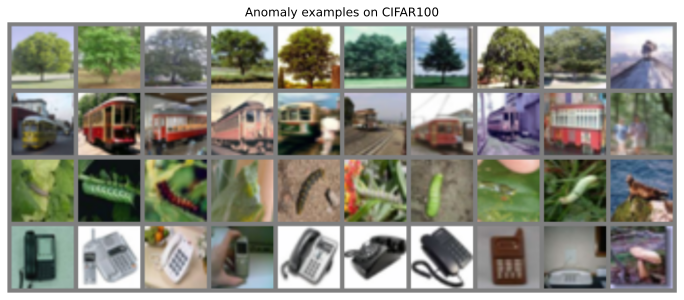

In [30]:
import urllib
from urllib.error import HTTPError

def visualize_exmp(indices, orig_dataset):
    images = [orig_dataset[idx][0] for idx in indices.reshape(-1)]
    images = torch.stack(images, dim=0)
    images = images * TORCH_DATA_STD + TORCH_DATA_MEANS
    
    img_grid = torchvision.utils.make_grid(images, nrow=SET_SIZE, normalize=True, pad_value=0.5, padding=16)
    img_grid = img_grid.permute(1, 2, 0)

    plt.figure(figsize=(12,8))
    plt.title("Anomaly examples on CIFAR100")
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()
    plt.close()



_, indices, _ =   next(iter(test_anom_loader))
visualize_exmp(indices[:4], test_set)

Predictor

In [31]:
class AnomalyPredictor(TransformerPredictor):
  def _calculate_loss(self, batch, mode = "train"):
    img_sets, _, labels = batch
    preds = self.forward(img_sets, add_positional_encoding = False)
    preds = preds.squeeze(dim=-1)
    loss = F.cross_entropy(preds, labels)
    acc = (preds.argmax(dim=-1) == labels).float().mean()

    self.log(f"{mode}_loss", loss)
    self.log(f"{mode}_acc", loss, acc, on_step = False, on_epoch = True)

    return loss, acc

  def training_step(self, batch, batch_idx):
    loss, _ = self._calculate_loss(batch, mode = "train")
    return loss

  def validation_step(self, batch, batch_idx):
    _ = self._calculate_loss(batch, mode="val")

  def test_step(self, batch, batch_idx):
    _ = self._calculate_loss(batch, mode="test")




Training

In [35]:
def train_anomaly(**kwargs):
  root_dir = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask")
  os.makedirs(root_dir, exist_ok= True)
  print(pl.trainer)
  trainer = pl.Trainer(default_root_dir = root_dir,
                       callbacks=[ModelCheckpoint(save_weights_only=True, mode = "max", monitor="val_acc")],
                       gpus = 1 if str(device).startswith('cuda') else 0,
                       max_epochs = 100,
                       gradient_clip_val=2,
                       progress_bar_refresh_rate=1
                       )
  
  trainer.logger._default_hp_metric = None

  pretrained_filename = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask.ckpt")

  if os.path.isfile(pretrained_filename):
    print("Fount pretrained model, loading...")
    model = AnomalyPredictor.load_from_checkpoint(pretrained_filename)
  
  else:
    model = AnomalyPredictor(max_iters=trainer.max_epochs*len(train_anom_loader), **kwargs)
    trainer.fit(model, train_anom_loader, val_anom_loader)

    model = AnomalyPredictor.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

  train_result = trainer.test(model, test_dataloaders = train_anom_loader, verbose = False)
  val_result = trainer.test(model, test_dataloaders = val_anom_loader, verbose = False)
  test_result = trainer.test(model, test_dataloaders = test_anom_loader, verbose = False)
  result = {
      "test_acc" : test_result[0]["test_acc"],
      "val_acc" : val_result[0]["test_acc"],
      "train_acc" : train_result[0]["test_acc"],
  }

  model = model.to(device)
  return model, result


In [36]:
anomaly_model, anomaly_result = train_anomaly(input_dim=train_anom_dataset.img_feats.shape[-1],
                                              model_dim=256,
                                              num_heads=4,
                                              num_classes=1,
                                              num_layers=4,
                                              dropout=0.1,
                                              input_dropout=0.1,
                                              lr=5e-4,
                                              warmup=100)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | input_net           | Sequential         | 131 K 
1 | positional_encoding | PositionalEncoding | 0     
2 | transformer         | TransformerEncoder | 2.1 M 
3 | output_net          | Sequential         | 66.6 K
-----------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.225     Total estimated model params size (MB)


<module 'pytorch_lightning.trainer' from '/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/__init__.py'>


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

In [37]:
print(f"Train accuracy: {(100.0*anomaly_result['train_acc']):4.2f}%")
print(f"Val accuracy:   {(100.0*anomaly_result['val_acc']):4.2f}%")
print(f"Test accuracy:  {(100.0*anomaly_result['test_acc']):4.2f}%")

Train accuracy: 46.48%
Val accuracy:   53.21%
Test accuracy:  49.99%


Evaluation

In [40]:
# Check model :: Is it premutation equivariant
inp_data, indices, labels = next(iter(test_anom_loader))
inp_data = inp_data.to(device)

anomaly_model.eval()

with torch.no_grad():
  preds = anomaly_model.forward(inp_data, add_positional_encoding = False)
  preds = F.softmax(preds.squeeze(dim=-1), dim=-1)

  # Premute input data
  permut = np.random.permutation(inp_data.shape[1])
  perm_inp_data = inp_data[:, permut]
  perm_preds = anomaly_model.forward(perm_inp_data, add_positional_encoding = False)
  perm_preds = F.softmax(perm_preds.squeeze(dim = -1), dim = -1)

assert (preds[:, permut] - perm_preds).abs().max() < 1e-5, "Predictions are not permutation equivariant"

print("Preds\n", preds[0, permut].cpu().numpy())
print("Permuted preds\n", perm_preds[0].cpu().numpy())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Preds
 [1.9646830e-04 2.0300123e-04 1.8192186e-03 1.4184955e-04 1.4628870e-04
 3.3795778e-04 3.0541481e-04 9.9615073e-01 4.8235187e-04 2.1673515e-04]
Permuted preds
 [1.9646827e-04 2.0300121e-04 1.8192150e-03 1.4184941e-04 1.4628883e-04
 3.3795740e-04 3.0541446e-04 9.9615061e-01 4.8235181e-04 2.1673473e-04]


In [41]:
attention_maps = anomaly_model.get_attention_maps(inp_data, add_positional_encoding=False)
predictions = preds.argmax(dim=-1)

In [44]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]
    
    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

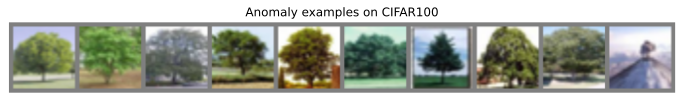

Prediction:  9


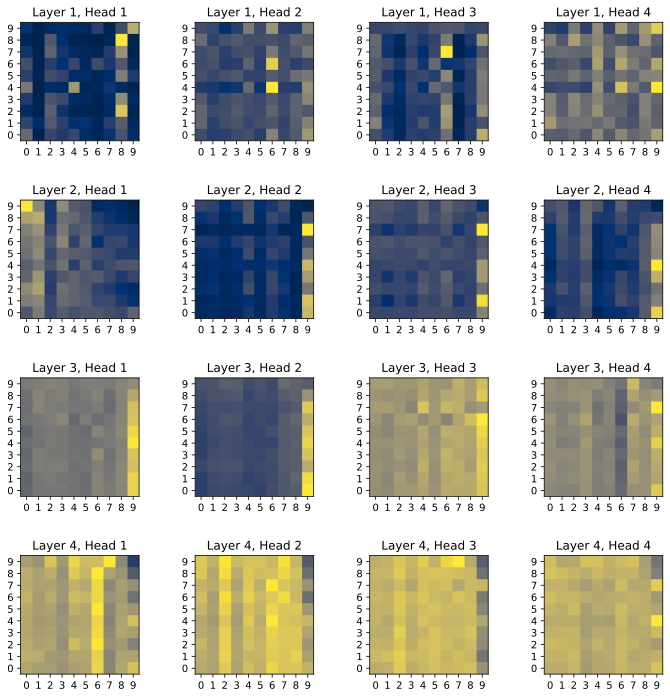

In [45]:
def visualize_prediction(idx):
  visualize_exmp(indices[idx:idx+1], test_set)
  print("Prediction: ", predictions[idx].item())
  plot_attention_maps(input_data=None, attn_maps=attention_maps, idx = idx)

visualize_prediction(0)

In [46]:
mistakes = torch.where(predictions != 9)[0].cpu().numpy()
print("Indices with mistake:", mistakes)

Indices with mistake: [11 24 30 39 40 48 49 58 60]


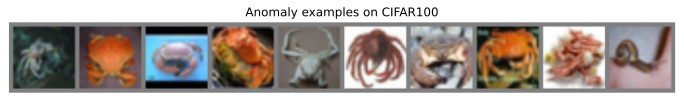

Prediction:  5


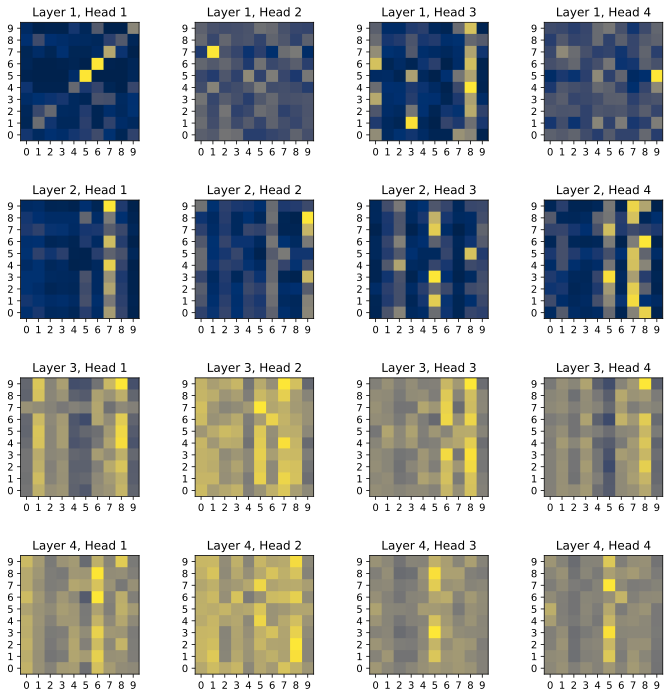

Probabilities
Image 0: 0.64%
Image 1: 0.48%
Image 2: 0.79%
Image 3: 0.22%
Image 4: 0.90%
Image 5: 92.45%
Image 6: 2.28%
Image 7: 0.42%
Image 8: 0.79%
Image 9: 1.01%


In [47]:
visualize_prediction(mistakes[-1])
print("Probabilities")

for i, p in enumerate(preds[mistakes[-1]].cpu().numpy()):
  print(f"Image {i}: {100.0*p:4.2f}%")